In [1]:
# create the configuration of the low-fidelity model
import matplotlib.pyplot as plt
import numpy as np
import torch

# get the accuracy metrics
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from mfbml.methods.mf_dnn_bnn import MFDNNBNN
from mfbml.methods.bnn import BNNWrapper
from mfbml.methods.sequential_mf_bnn import SequentialMFBNN
from mfbml.problems.high_dimension_problems import MengCase1
from mfbml.metrics import (
    mean_log_likelihood_value,
    normalized_mae,
    normalized_rmse,
)

# fix the random seed for reproducibility
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
# define function
func = MengCase1(noise_std=0.05)

# generate samples (21 HF samples, 201 LF samples)
lf_samples = torch.linspace(0, 1, 201).reshape(-1, 1)
hf_samples = lf_samples[::10]  # sample every 5 points

# generate responses
lf_responses = func.lf(lf_samples)
hf_responses = func.hf(hf_samples)

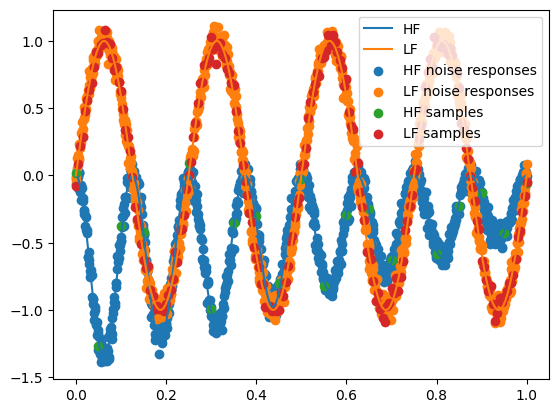

In [3]:
# generate the test points
test_samples = torch.linspace(0, 1, 1001).reshape(-1, 1)
# noiseless responses
test_hf_responses_noiseless = func.hf(test_samples, noise_hf=0.0)
test_lf_responses_noiseless = func.lf(test_samples, noise_lf=0.0)

# noise responses
test_hf_responses = func.hf(test_samples)
test_lf_responses = func.lf(test_samples)

# plot the function
fig, ax = plt.subplots()
ax.plot(test_samples, test_hf_responses_noiseless, label="HF")
ax.plot(test_samples, test_lf_responses_noiseless, label="LF")
# plot test noisy responses
ax.scatter(test_samples, test_hf_responses, label="HF noise responses")
ax.scatter(test_samples, test_lf_responses, label="LF noise responses")
# plot the samples
ax.scatter(hf_samples, hf_responses, label="HF samples")
ax.scatter(lf_samples, lf_responses, label="LF samples")
plt.legend()
plt.show()

In [4]:
# calculate the person correlation coefficient via the noiseless responses
rho, pval = pearsonr(
    test_hf_responses_noiseless.flatten().numpy().tolist(),
    test_lf_responses_noiseless.flatten().numpy().tolist(),
)
print("rho: ", rho)
print("pval: ", pval)

rho:  -0.10188648995412593
pval:  0.0012469388228371753


## Configurations for DNN and BNNs


In [5]:
# create the configuration of the low-fidelity model
lf_configure = {
    "in_features": 1,
    "hidden_features": [20, 20],
    "out_features": 1,
    "activation": "Tanh",
    "optimizer": "Adam",
    "lr": 0.001,
    "weight_decay": 0.000001,
    "loss": "mse",
}
# create the configuration of the high-fidelity model
hf_parallel_configure = {
    "in_features": 1,
    "hidden_features": [50, 50],
    "out_features": 1,
    "activation": "Tanh",
    "lr": 0.001,
    "sigma": 0.05,
}
#
hf_sequential_configure = {
    "in_features": 2,
    "hidden_features": [50, 50],
    "out_features": 1,
    "activation": "Tanh",
    "lr": 0.001,
    "sigma": 0.05,
}

# training configure
samples = {"lf": lf_samples, "hf": hf_samples}

responses = {"lf": lf_responses, "hf": hf_responses}

# lf train config
lf_train_config = {
    "batch_size": None,
    "num_epochs": 10000,
    "print_iter": 100,
    "data_split": False,
}
hf_train_config = {
    "num_epochs": 20000,
    "sample_freq": 100,
    "print_info": True,
    "burn_in_epochs": 10000,
}

### train standard BNN using HF data


In [6]:
# define BNN
bnn_model = BNNWrapper(
    in_features=1,
    hidden_features=[50, 50],
    out_features=1,
    activation="Tanh",
    lr=0.001,
    sigma=0.05,
)

# train the model
bnn_model.train(
    x=hf_samples,
    y=hf_responses,
    num_epochs=20000,
    sample_freq=100,
    burn_in_epochs=10000,
)

epoch:     0/20000
nll_loss: 1599.520, prior_loss: 2507.730, total: 4107.250
noise: 0.050


/home/yaga/Documents/mfbml/src/mfbml/methods/bnn.py:170: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)
  V.mul_(alpha).addcmul_(1 - alpha, d_p, d_p)


epoch:   100/20000
nll_loss: 494.108, prior_loss: 2539.092, total: 3033.199
noise: 0.050
epoch:   200/20000
nll_loss: 471.930, prior_loss: 2569.483, total: 3041.413
noise: 0.050
epoch:   300/20000
nll_loss: 473.818, prior_loss: 2597.690, total: 3071.509
noise: 0.050
epoch:   400/20000
nll_loss: 480.672, prior_loss: 2631.592, total: 3112.264
noise: 0.050
epoch:   500/20000
nll_loss: 480.851, prior_loss: 2658.492, total: 3139.342
noise: 0.050
epoch:   600/20000
nll_loss: 470.770, prior_loss: 2697.327, total: 3168.097
noise: 0.050
epoch:   700/20000
nll_loss: 473.064, prior_loss: 2742.069, total: 3215.134
noise: 0.050
epoch:   800/20000
nll_loss: 473.441, prior_loss: 2783.529, total: 3256.970
noise: 0.050
epoch:   900/20000
nll_loss: 468.785, prior_loss: 2829.302, total: 3298.088
noise: 0.050
epoch:  1000/20000
nll_loss: 466.164, prior_loss: 2864.539, total: 3330.703
noise: 0.050
epoch:  1100/20000
nll_loss: 468.718, prior_loss: 2898.944, total: 3367.661
noise: 0.050
epoch:  1200/20000
nl

epoch:  1700/20000
nll_loss: 484.751, prior_loss: 3093.693, total: 3578.444
noise: 0.050
epoch:  1800/20000
nll_loss: 472.582, prior_loss: 3124.775, total: 3597.357
noise: 0.050
epoch:  1900/20000
nll_loss: 466.412, prior_loss: 3158.851, total: 3625.263
noise: 0.050
epoch:  2000/20000
nll_loss: 463.698, prior_loss: 3194.407, total: 3658.105
noise: 0.050
epoch:  2100/20000
nll_loss: 465.121, prior_loss: 3220.078, total: 3685.198
noise: 0.050
epoch:  2200/20000
nll_loss: 491.094, prior_loss: 3256.183, total: 3747.278
noise: 0.050
epoch:  2300/20000
nll_loss: 462.888, prior_loss: 3262.977, total: 3725.866
noise: 0.050
epoch:  2400/20000
nll_loss: 462.791, prior_loss: 3297.925, total: 3760.716
noise: 0.050
epoch:  2500/20000
nll_loss: 463.349, prior_loss: 3311.292, total: 3774.641
noise: 0.050
epoch:  2600/20000
nll_loss: 460.141, prior_loss: 3334.332, total: 3794.473
noise: 0.050
epoch:  2700/20000
nll_loss: 459.939, prior_loss: 3354.565, total: 3814.504
noise: 0.050
epoch:  2800/20000
nl

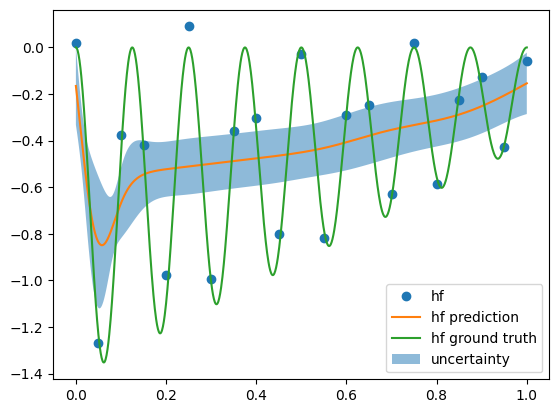

In [7]:
# visualize the posterior of bnn
bnn_y, bnn_epistemic, bnn_total_unc, bnn_aleatoric = bnn_model.predict(
    x=test_samples)

# plot
plt.figure()
plt.plot(hf_samples, hf_responses, "o", label="hf")
plt.plot(test_samples.numpy(), bnn_y, label="hf prediction")
plt.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
plt.fill_between(
    test_samples.flatten().numpy(),
    (bnn_y - 2 * bnn_total_unc).reshape(-1),
    (bnn_y + 2 * bnn_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
plt.legend()
# plt.savefig("bnn.png", bbox_inches='tight', dpi=300)
plt.show()

# training of sequential MF-DNN-BNN model


In [8]:
# sequential mf-bnn
sequential_bnn = SequentialMFBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_sequential_configure,
)
# train the model
sequential_bnn.train(
    samples=samples,
    responses=responses,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

No data split: use all data for training
epoch:  100 train loss:  0.9624431729316711
epoch:  200 train loss:  0.9618332386016846
epoch:  300 train loss:  0.9611150622367859
epoch:  400 train loss:  0.960101306438446
epoch:  500 train loss:  0.9578113555908203
epoch:  600 train loss:  0.9417469501495361
epoch:  700 train loss:  0.9045171737670898
epoch:  800 train loss:  0.8871129155158997
epoch:  900 train loss:  0.8605265617370605
epoch:  1000 train loss:  0.7798553109169006
epoch:  1100 train loss:  0.6030156016349792
epoch:  1200 train loss:  0.4177820682525635
epoch:  1300 train loss:  0.19997456669807434
epoch:  1400 train loss:  0.05510484054684639
epoch:  1500 train loss:  0.023162182420492172
epoch:  1600 train loss:  0.01364896446466446
epoch:  1700 train loss:  0.009436127729713917
epoch:  1800 train loss:  0.007395498920232058
epoch:  1900 train loss:  0.006409354042261839
epoch:  2000 train loss:  0.0059081027284264565
epoch:  2100 train loss:  0.00561639666557312
epoch:  2

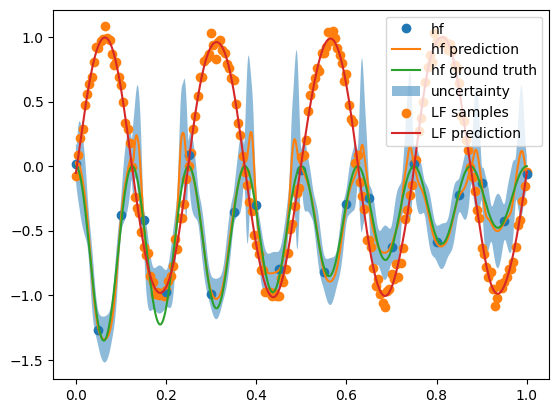

In [9]:
# visualize the posterior of sequential mf-bnn
(
    sequential_bnn_y,
    sequential_bnn_epistemic,
    sequential_bnn_total_unc,
    sequential_bnn_aleatoric,
) = sequential_bnn.predict(x=test_samples)
# get lf predictions
sequential_bnn_lf_y = sequential_bnn.predict_lf(x=test_samples)
# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), sequential_bnn_y, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (sequential_bnn_y - 2 * sequential_bnn_total_unc).reshape(-1),
    (sequential_bnn_y + 2 * sequential_bnn_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot lf samples
ax.scatter(lf_samples, lf_responses, label="LF samples")
ax.plot(
    test_samples.numpy(), sequential_bnn_lf_y.detach().numpy(), label="LF prediction"
)
ax.legend()
plt.show()

In [10]:
# create the MFDNNBNN object
mfdnnbnn = MFDNNBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_parallel_configure,
    beta_optimize=False,
    beta_bounds=[-5, 5],
    discrepancy_normalization="hf",
)
# define beta
mfdnnbnn.beta = np.array([0.0, 2.0])
mfdnnbnn.train(
    samples=samples,
    responses=responses,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

No data split: use all data for training
epoch:  100 train loss:  0.9622259140014648
epoch:  200 train loss:  0.9617745280265808
epoch:  300 train loss:  0.9609943628311157
epoch:  400 train loss:  0.9585341811180115
epoch:  500 train loss:  0.9352924227714539
epoch:  600 train loss:  0.8974278569221497
epoch:  700 train loss:  0.8642897009849548
epoch:  800 train loss:  0.7568215727806091
epoch:  900 train loss:  0.6039595007896423
epoch:  1000 train loss:  0.4132484793663025
epoch:  1100 train loss:  0.17233042418956757
epoch:  1200 train loss:  0.04675375670194626
epoch:  1300 train loss:  0.017782654613256454
epoch:  1400 train loss:  0.011724021285772324
epoch:  1500 train loss:  0.009485170245170593
epoch:  1600 train loss:  0.008476820774376392
epoch:  1700 train loss:  0.007870410569012165
epoch:  1800 train loss:  0.007395067717880011
epoch:  1900 train loss:  0.0069825006648898125
epoch:  2000 train loss:  0.006619123741984367
epoch:  2100 train loss:  0.00630158232524991


epoch:  2200 train loss:  0.006027011200785637
epoch:  2300 train loss:  0.005791717674583197
epoch:  2400 train loss:  0.005592407658696175
epoch:  2500 train loss:  0.005423831287771463
epoch:  2600 train loss:  0.005281015299260616
epoch:  2700 train loss:  0.005159799940884113
epoch:  2800 train loss:  0.005059403367340565
epoch:  2900 train loss:  0.004976984113454819
epoch:  3000 train loss:  0.004909304901957512
epoch:  3100 train loss:  0.004853145685046911
epoch:  3200 train loss:  0.00480537349358201
epoch:  3300 train loss:  0.0047641536220908165
epoch:  3400 train loss:  0.004727825988084078
epoch:  3500 train loss:  0.0046952818520367146
epoch:  3600 train loss:  0.004665686748921871
epoch:  3700 train loss:  0.004638210870325565
epoch:  3800 train loss:  0.004612898454070091
epoch:  3900 train loss:  0.004589262418448925
epoch:  4000 train loss:  0.004567024763673544
epoch:  4100 train loss:  0.004545990377664566
epoch:  4200 train loss:  0.004526560660451651
epoch:  4300

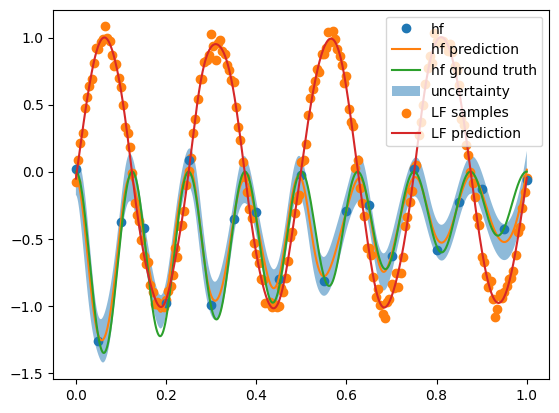

In [11]:
# predict the MFDNNBNN object
(
    y_proposed,
    epistemic_proposed,
    total_unc_proposed,
    aleatoric_proposed,
) = mfdnnbnn.predict(x=test_samples)
# lf prediction
lf_y_proposed = mfdnnbnn.predict_lf(test_samples)

# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), y_proposed, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (y_proposed - 2 * total_unc_proposed).reshape(-1),
    (y_proposed + 2 * total_unc_proposed).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot lf samples
ax.scatter(lf_samples, lf_responses, label="LF samples")
ax.plot(test_samples.numpy(), lf_y_proposed.detach().numpy(),
        label="LF prediction")
ax.legend()
plt.show()

In [12]:
print("=====================================")
print("BNN")
nrmse_bnn = normalized_rmse(test_hf_responses_noiseless.numpy(), bnn_y)
print("nrmse: ", nrmse_bnn)
nmae_bnn = normalized_mae(test_hf_responses_noiseless.numpy(), bnn_y)
print("nmae: ", nmae_bnn)
ll_bnn = mean_log_likelihood_value(
    test_hf_responses.numpy(), bnn_y, bnn_total_unc)
print("ll_bnn: ", ll_bnn)
# r2 score
print("=====================================")
print("R2 Score")
print("BNN: ", r2_score(test_hf_responses_noiseless.numpy(), bnn_y))
# sequential mf-bnn
print("=====================================")
print("Sequential MF-BNN")
nrmse_sequential_bnn = normalized_rmse(
    test_hf_responses_noiseless.numpy(), sequential_bnn_y
)
print("nrmse: ", nrmse_sequential_bnn)
nmae_sequential_bnn = normalized_mae(
    test_hf_responses_noiseless.numpy(), sequential_bnn_y
)
print("nmae: ", nmae_sequential_bnn)
ll_sequential_bnn = mean_log_likelihood_value(
    test_hf_responses.numpy(),
    sequential_bnn_y,
    sequential_bnn_total_unc,
)
print("ll_sequential_bnn: ", ll_sequential_bnn)
# R2 Score
print("=====================================")
print("R2 Score")
print("BNN: ", r2_score(test_hf_responses_noiseless.numpy(), sequential_bnn_y))
# MFDNNBNN
print("=====================================")
print("MFDNNBNN")
nrmse_mfdnnbnn = normalized_rmse(
    test_hf_responses_noiseless.numpy(), y_proposed)
print("nrmse: ", nrmse_mfdnnbnn)
nmae_mfdnnbnn = normalized_mae(test_hf_responses_noiseless.numpy(), y_proposed)
print("nmae: ", nmae_mfdnnbnn)
ll_mfdnnbnn = mean_log_likelihood_value(
    test_hf_responses.numpy(), y_proposed, total_unc_proposed
)
print("ll_mfdnnbnn: ", ll_mfdnnbnn)
# R2 Score
print("=====================================")
print("R2 Score")
print("BNN: ", r2_score(test_hf_responses_noiseless.numpy(), y_proposed))

BNN
nrmse:  0.70194715
nmae:  1.534659
ll_bnn:  -11.695831
R2 Score
BNN:  0.24129081341062686
Sequential MF-BNN
nrmse:  0.22952382
nmae:  0.8797145
ll_sequential_bnn:  0.86706805
R2 Score
BNN:  0.9188811067445558
MFDNNBNN
nrmse:  0.195941
nmae:  0.52964485
ll_mfdnnbnn:  0.7015287
R2 Score
BNN:  0.94088235656399


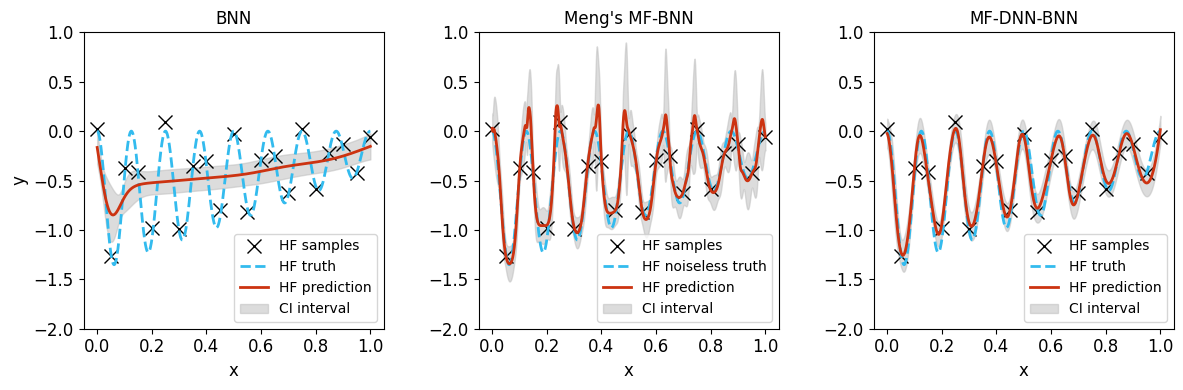

In [13]:
font_size = 12
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# plot results of bnn
ax[0].plot(
    samples["hf"].numpy(),
    responses["hf"].numpy(),
    "kx",
    linewidth=2,
    markersize=10,
    label="HF samples",
)
ax[0].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)
ax[0].plot(
    test_samples.numpy(),
    bnn_y,
    "-",
    color="#CC3311",
    linewidth=2,
    label="HF prediction",
)
ax[0].fill_between(
    test_samples.flatten(),
    (bnn_y - 2 * bnn_total_unc).flatten(),
    (bnn_y + 2 * bnn_total_unc).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
ax[0].legend(loc="lower right")
ax[0].set_title("BNN", fontsize=font_size)
ax[0].set_xlabel("x", fontsize=font_size)
ax[0].set_ylabel("y", fontsize=font_size)
ax[0].tick_params(labelsize=font_size)
ax[0].set_ylim([-2, 1.0])

#  plot for sequential mf-bnn
ax[1].plot(
    samples["hf"].numpy(),
    responses["hf"].numpy(),
    "kx",
    linewidth=2,
    markersize=10,
    label="HF samples",
)
ax[1].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF noiseless truth",
)
ax[1].plot(
    test_samples.numpy(),
    sequential_bnn_y,
    "-",
    color="#CC3311",
    linewidth=2,
    label="HF prediction",
)

ax[1].fill_between(
    test_samples.flatten().numpy(),
    (sequential_bnn_y - 2 * sequential_bnn_total_unc).flatten(),
    (sequential_bnn_y + 2 * sequential_bnn_total_unc).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
ax[1].legend(loc="lower right")
ax[1].set_title("Meng's MF-BNN", fontsize=font_size)
ax[1].set_xlabel("x", fontsize=font_size)
ax[1].set_ylabel(" ", fontsize=font_size)
ax[1].tick_params(labelsize=font_size)
ax[1].set_ylim([-2, 1.0])

# plot for MFDNNBNN
ax[2].plot(
    samples["hf"].numpy(),
    responses["hf"].numpy(),
    "kx",
    linewidth=2,
    markersize=10,
    label="HF samples",
)
ax[2].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)
ax[2].plot(
    test_samples.numpy(),
    y_proposed,
    "-",
    color="#CC3311",
    linewidth=2,
    label="HF prediction",
)

ax[2].fill_between(
    test_samples.flatten().numpy(),
    (y_proposed - 2 * total_unc_proposed).flatten(),
    (y_proposed + 2 * total_unc_proposed).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)

ax[2].set_title("MF-DNN-BNN", fontsize=font_size)
ax[2].set_xlabel("x", fontsize=font_size)
ax[2].set_ylabel(" ", fontsize=font_size)
ax[2].tick_params(labelsize=font_size)
ax[2].set_ylim([-2, 1.0])
ax[2].legend(loc="lower right")
plt.tight_layout()
plt.savefig("mf_dnn_bnn_known_noise.pdf", dpi=300, bbox_inches="tight")
plt.savefig("mf_dnn_bnn_known_noise.png", dpi=300, bbox_inches="tight")
plt.savefig("mf_dnn_bnn_known_noise.svg", dpi=300, bbox_inches="tight")
plt.show()

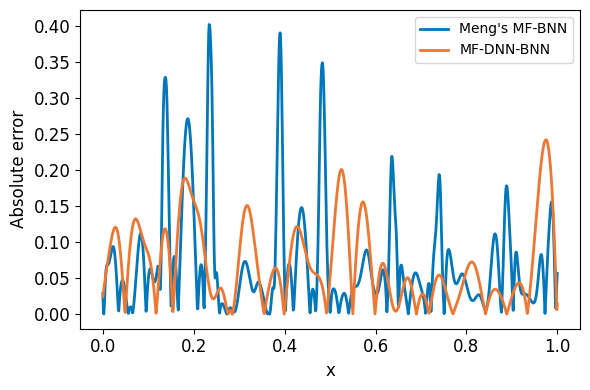

In [14]:
# error plot
fig, ax = plt.subplots(1, figsize=(6, 4))
# plot for sequential mf-bnn
ax.plot(
    test_samples.numpy(),
    np.abs(test_hf_responses_noiseless.numpy() - sequential_bnn_y),
    "-",
    color="#0077BB",
    linewidth=2,
    label="Meng's MF-BNN",
)
ax.plot(
    test_samples.numpy(),
    np.abs(test_hf_responses_noiseless.numpy() - y_proposed),
    "-",
    color="#EE7733",
    linewidth=2,
    label="MF-DNN-BNN",
)
ax.set_xlabel("x", fontsize=font_size)
ax.set_ylabel("Absolute error", fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.legend()
plt.tight_layout()
plt.savefig("mf_dnn_bnn_known_noise_error.pdf", dpi=300, bbox_inches="tight")
plt.savefig("mf_dnn_bnn_known_noise_error.png", dpi=300, bbox_inches="tight")
plt.savefig("mf_dnn_bnn_known_noise_error.svg", dpi=300, bbox_inches="tight")
plt.show()